Servers: Running Jobs on External Compute Resources
============================


Setup
-----------------------------

Let's first make sure we have the latest version of PHOEBE 2.4 installed (uncomment this line if running in an online notebook session such as colab).

In [1]:
#!pip install -I "phoebe>=2.4,<2.5"

In [2]:
import phoebe
from phoebe import u # units
import numpy as np

logger = phoebe.logger('error')

b = phoebe.default_binary()
b.add_dataset('lc', compute_times=phoebe.linspace(0,1,501))
b.add_solver('optimizer.nelder_mead', solver='nm_solver')

<ParameterSet: 13 parameters | qualifiers: priors_combine, compute, use_server, fatol, adaptive, expose_lnprobabilities, initial_values, xatol, maxiter, maxfev, fit_parameters, priors, comments>

PHOEBE makes use of [crimpl](http://crimpl.readthedocs.io) as a built-in depedency to manage submitting and monitoring jobs on external compute resources.  In order to make use of one of these server, you must first configure the server within [crimpl](http://crimpl.readthedocs.io) (this only needs to be done once, after which the name of the crimpl server can be referenced from within PHOEBE on your local machine).

The available server types include:
* [LocalThread](https://crimpl.readthedocs.io/en/latest/LocalThread/)
* [RemoteSlurm](https://crimpl.readthedocs.io/en/latest/RemoteSlurm/)
* [AWSEC2](https://crimpl.readthedocs.io/en/latest/AWSEC2/)

As the configuration for remote servers can differ significantly and to keep this example working for all users, we'll initialize a [LocalThread](https://crimpl.readthedocs.io/en/latest/LocalThread/) server in order to run our compute and solver jobs within MPI while running the rest of the commands in this notebook on a single processor.  Besides the crimpl configuration itself and a few different exposed options in the bundle (which we will briefly overview), the servers can essentially be swapped.

In [3]:
from phoebe.dependencies import crimpl

In [4]:
s = crimpl.LocalThreadServer()

In [5]:
print(s)

<LocalThreadServer directory=/home/kyle/crimpl>


In [6]:
s.save('local', overwrite=True)

'/home/kyle/.crimpl/servers/local.json'

The name provided when saving the crimpl configuration is the same name that we will reference later in PHOEBE as `crimpl_name`.  This keeps all the server configuration and potential sensitive information out of the bundle or so that the bundle (or notebook) can safely be saved and shared, while also not requiring the servers to be re-configured in each case.  If `crimpl_name` is not available from `crimpl` on the local machine, an error will be raised and the server can easily be configured or swapped.

Servers in the Bundle
-------------------------------

Servers in the bundle are added and managed as any other set of options via [b.add_server](../api/phoebe.frontend.bundle.Bundle.add_server.md) and with "kinds" for each of the supported crimpl server types listed above:

* [localthread](../api/phoebe.parameters.server.localthread.md)
* [remoteslurm](../api/phoebe.parameters.server.remoteslurm.md)
* [awsec2](../api/phoebe.parameters.server.awsec2.md)

In [7]:
b.add_server('localthread', crimpl_name='local',
             server='mylocalserver', overwrite=True)

<ParameterSet: 7 parameters | qualifiers: conda_env, use_mpi, nprocs, install_deps, crimpl_name, use_conda, isolate_env>

In [9]:
print(b.get_server('mylocalserver'))

ParameterSet: 5 parameters
   crimpl_name@mylocalserver@s...: local
   use_conda@mylocalserver@server: False
     use_mpi@mylocalserver@server: True
      nprocs@mylocalserver@server: 4
   install_deps@mylocalserver@...: True


In this case, we'll skip having crimpl install the necessary dependencies, as we know they are already installed.  If running PHOEBE in a conda environment locally, you could set `use_conda=True` and reference the same conda environment in the then-exposed `conda_env` parameter.

In [10]:
b.set_value('install_deps', False)

use_server parameters
--------------------------

compute and solver options both have `use_server` parameters that will then dictate how [b.run_compute](../api/phoebe.frontend.bundle.Bundle.run_compute.md) and [b.run_solver](../api/phoebe.frontend.bundle.Bundle.run_solver.md) should handle running on external resources.  

If 'none' (as by default), the job is run in the current thread.  `use_server` in solver options are set to 'compute' by default, which means they will fallback on the `use_server` parameter in the referenced compute options.

In [11]:
print(b.filter(qualifier='use_server'))

ParameterSet: 2 parameters
      use_server@phoebe01@compute: none
      use_server@nm_solver@solver: compute


So in this case, if running the `nm_solver`, PHOEBE will use the solver options for the `phoebe01` compute options.

In [12]:
print(b.filter(qualifier='compute'))

ParameterSet: 1 parameters
         compute@nm_solver@solver: phoebe01


As with any other parameter in compute or solver options, these can either be set or overridden as keyword arguments when calling [b.run_compute](../api/phoebe.frontend.bundle.Bundle.run_compute.md) and [b.run_solver](../api/phoebe.frontend.bundle.Bundle.run_solver.md), respectively.

Running External Jobs with crimpl
--------------------------------

There are several different use-cases for running compute or solver jobs on external servers

### 1. wait and load results automatically

As always, we can send kwargs to `run_compute` or `run_solver` to override any compute/solver options.  Here we can pass the server tag (note: this is the PHOEBE server tag, not the crimpl server name) to `run_compute` overriding the `use_server` parameter, which then looks up the server options, loads the corresponding crimpl object, and passes the job to the remote (albeit not so remote in this case) machine.

In [13]:
b.run_compute(use_server='mylocalserver')

# crimpl: ls -d /home/kyle/crimpl/crimpl-job-*
# crimpl: ls /home/kyle/crimpl/crimpl-job-2021.05.06-13.36.45/*
# crimpl: mkdir -p /home/kyle/crimpl
# crimpl: cp exportpath.sh /home/kyle/crimpl/
# crimpl: source /home/kyle/crimpl/exportpath.sh; conda -V
# crimpl: source /home/kyle/crimpl/exportpath.sh; mkdir -p /home/kyle/crimpl/crimpl-job-2021.05.06-13.36.45
# crimpl: cp crimpl_submit_script.sh /home/kyle/research/phoebe_git/phoebe2-docs/tutorials/_HNSWQEFBBgKUsfeGXekjkKpZYGiIDC.py /home/kyle/crimpl/crimpl-job-2021.05.06-13.36.45/
# crimpl: source /home/kyle/crimpl/exportpath.sh; echo '_HNSWQEFBBgKUsfeGXekjkKpZYGiIDC.py' >> /home/kyle/crimpl/crimpl-job-2021.05.06-13.36.45/crimpl-input-files.list
# crimpl: source /home/kyle/crimpl/exportpath.sh; echo 'False' > /home/kyle/crimpl/crimpl-job-2021.05.06-13.36.45/crimpl-conda-environment
# crimpl (detached): source /home/kyle/crimpl/exportpath.sh; cd /home/kyle/crimpl/crimpl-job-2021.05.06-13.36.45; chmod +x ./crimpl_submit_script.sh; nohup 

<ParameterSet: 3 parameters | qualifiers: comments, fluxes, times>

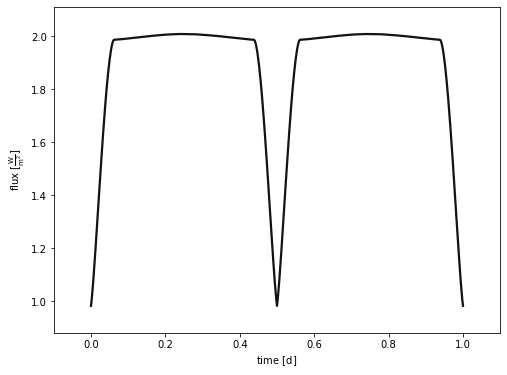

In [14]:
_ = b.plot(show=True)

### 2. detach and monitor/retrieve results 

For long jobs, we can submit the job and immediately detach from `run_compute` or `run_solver`.  This results in a a "Job Parameter" in the model or solution holding the necessary information to check the progress and retrieve the results at any time in the future. 

In [15]:
b.run_compute(use_server='mylocalserver', detach=True)

# crimpl: ls -d /home/kyle/crimpl/crimpl-job-*
# crimpl: ls /home/kyle/crimpl/crimpl-job-2021.05.06-13.36.55/*
# crimpl: source /home/kyle/crimpl/exportpath.sh; conda -V
# crimpl: source /home/kyle/crimpl/exportpath.sh; mkdir -p /home/kyle/crimpl/crimpl-job-2021.05.06-13.36.55
# crimpl: cp crimpl_submit_script.sh /home/kyle/research/phoebe_git/phoebe2-docs/tutorials/_KSeBWOzxpVtkYbWXvLANIsUoHZHjzm.py /home/kyle/crimpl/crimpl-job-2021.05.06-13.36.55/
# crimpl: source /home/kyle/crimpl/exportpath.sh; echo '_KSeBWOzxpVtkYbWXvLANIsUoHZHjzm.py' >> /home/kyle/crimpl/crimpl-job-2021.05.06-13.36.55/crimpl-input-files.list
# crimpl: source /home/kyle/crimpl/exportpath.sh; echo 'False' > /home/kyle/crimpl/crimpl-job-2021.05.06-13.36.55/crimpl-conda-environment
# crimpl (detached): source /home/kyle/crimpl/exportpath.sh; cd /home/kyle/crimpl/crimpl-job-2021.05.06-13.36.55; chmod +x ./crimpl_submit_script.sh; nohup bash ./crimpl_submit_script.sh 2>&1 & echo $! > crimpl-nohup.pid


<Parameter: detached_job=unknown | keys: description, value, job_name, uniqueid, readonly, advanced, latexfmt>

In [16]:
print(b.get_model())

ParameterSet: 2 parameters
R       detached_job@latest@model: unknown
            comments@latest@model: 


We can now (optionally) save the bundle, turn off our local machine, start a new python session, load the bundle, and all necessary information to check the job's status and retrieve results are handled automatically (with job information in the detached_job parameter and server setup/credentials in the crimpl configuration to avoid any security concerns when sharing bundles).

In [17]:
b.save('running_job.phoebe')

import phoebe
b = phoebe.open('running_job.phoebe')

Depending on how long we expect the job to take, we have a number of available methods we can call to act on this detached job parameter:

* [b.get_job_status](../api/phoebe.frontend.bundle.Bundle.get_job_status.md)
* [b.get_job_crimpl_object](../api/phoebe.frontend.bundle.Bundle.get_job_crimpl_object.md)
* [b.attach_job](../api/phoebe.frontend.bundle.Bundle.attach_job.md)
* [b.load_job_progress](../api/phoebe.frontend.bundle.Bundle.load_job_progress.md)
* [b.kill_job](../api/phoebe.frontend.bundle.Bundle.kill_job.md)
* [b.resubmit_job](../api/phoebe.frontend.bundle.Bundle.resubmit_job.md)

Here we'll call [b.attach_job](../api/phoebe.frontend.bundle.Bundle.attach_job.md), which will re-enter the loop waiting for the job to complete and then load the results.

In [18]:
b.attach_job()

# crimpl: ls -d /home/kyle/crimpl/crimpl-job-*
# crimpl: cat /home/kyle/crimpl/crimpl-job-2021.05.06-13.36.55/crimpl-job.status
# crimpl: cat /home/kyle/crimpl/crimpl-job-2021.05.06-13.36.55/crimpl-job.status
# crimpl: cat /home/kyle/crimpl/crimpl-job-2021.05.06-13.36.55/crimpl-job.status
# crimpl: ls /home/kyle/crimpl/crimpl-job-2021.05.06-13.36.55/*
# crimpl: ls /home/kyle/crimpl/crimpl-job-2021.05.06-13.36.55/*
# crimpl: cp /home/kyle/crimpl/crimpl-job-2021.05.06-13.36.55/_KSeBWOzxpVtkYbWXvLANIsUoHZHjzm.out ./


<ParameterSet: 3 parameters | qualifiers: comments, fluxes, times>

### 3. export script and submit manually

And lastly, for cases where we want to run the job later or _from_ a different machine, we can call [b.export_compute](../api/phoebe.frontend.bundle.Bundle.export_compute.md) (or [b.export_solver](../api/phoebe.frontend.bundle.Bundle.export_solver.md)).  If `use_server` is 'none', this exports the python script directly.  If `use_server` is not 'none', this exports a script which accepts the following command-line options:

* `export_compute_to_server.py submit` to submit the job to the server according to the set options
* `export_compute_to_server.py status` to query the status of the job on the remote server
* `export_compute_to_server.py wait` to query the status until complete or failed
* `export_compute_to_server.py output` to retrieve the results
* `export_compute_to_server.py kill` to terminate a job before it completes
* `export_compute_to_server.py continue` to continue a job.  Only supported for solvers that have a `continue_from` parameter.

Once the job is complete and the results retrieved, we can then call [b.import_model](../api/phoebe.frontend.bundle.Bundle.import_model.md) (or [b.import_solution](../api/phoebe.frontend.bundle.Bundle.import_solution.md)).

In [19]:
script_fname, results_fname = b.export_compute('export_compute_to_server.py', 
                                               use_server='mylocalserver')

Note that the top of this file includes the `crimpl` options themselves, allowing the script to easily be modified to change the compute resources (particularly handy if sharing this file with a collaborator).

In [20]:
!head export_compute_to_server.py

crimpl_name = 'local'
nprocs = 4
use_mpi = True
use_conda = False
conda_env = 'default'
install_deps = False
job_name = '2021.05.06-13.37.07'
server_options = {'isolate_env': False}




If we just call the exported script, we'll see that it provides the available command-line arguments.

In [22]:
!python3 export_compute_to_server.py

usage: export_compute_to_server.py [submit, status, wait, output, kill]


We can now use these command line arguments to submit the script, check its status, wait for it to complete, and retrieve any output files.

In [23]:
!python3 export_compute_to_server.py submit

# crimpl: ls -d /home/kyle/crimpl/crimpl-job-*
# crimpl: ls -d /home/kyle/crimpl/crimpl-job-*
# crimpl: ls /home/kyle/crimpl/crimpl-job-2021.05.06-13.37.07/*
# crimpl: mkdir -p /home/kyle/crimpl
# crimpl: cp exportpath.sh /home/kyle/crimpl/
# crimpl: source /home/kyle/crimpl/exportpath.sh; conda -V
# crimpl: source /home/kyle/crimpl/exportpath.sh; mkdir -p /home/kyle/crimpl/crimpl-job-2021.05.06-13.37.07
# crimpl: cp crimpl_submit_script.sh /home/kyle/crimpl/crimpl-job-2021.05.06-13.37.07/
# crimpl: source /home/kyle/crimpl/exportpath.sh; echo 'server_tmp_script.py' >> /home/kyle/crimpl/crimpl-job-2021.05.06-13.37.07/crimpl-input-files.list
# crimpl: source /home/kyle/crimpl/exportpath.sh; echo 'False' > /home/kyle/crimpl/crimpl-job-2021.05.06-13.37.07/crimpl-conda-environment
# crimpl (detached): source /home/kyle/crimpl/exportpath.sh; cd /home/kyle/crimpl/crimpl-job-2021.05.06-13.37.07; chmod +x ./crimpl_submit_script.sh; nohup bash ./crimpl_submit_script.sh 2>&1 & echo $! > crimpl-n

In [24]:
!python3 export_compute_to_server.py wait

# crimpl: ls -d /home/kyle/crimpl/crimpl-job-*
# crimpl: cat /home/kyle/crimpl/crimpl-job-2021.05.06-13.37.07/crimpl-job.status
# crimpl: job_status=running
# crimpl: cat /home/kyle/crimpl/crimpl-job-2021.05.06-13.37.07/crimpl-job.status
# crimpl: job_status=running
# crimpl: cat /home/kyle/crimpl/crimpl-job-2021.05.06-13.37.07/crimpl-job.status
# crimpl: job_status=complete


In [25]:
!python3 export_compute_to_server.py output

# crimpl: ls -d /home/kyle/crimpl/crimpl-job-*
# crimpl: ls /home/kyle/crimpl/crimpl-job-2021.05.06-13.37.07/*
# crimpl: cat /home/kyle/crimpl/crimpl-job-2021.05.06-13.37.07/crimpl-input-files.list
# crimpl: cp /home/kyle/crimpl/crimpl-job-2021.05.06-13.37.07/export_compute_to_server.py.out ./
# crimpl: cp /home/kyle/crimpl/crimpl-job-2021.05.06-13.37.07/nohup.out ./
['export_compute_to_server.py.out', 'nohup.out']


In [26]:
b.import_model('export_compute_to_server.py.out', overwrite=True)

<ParameterSet: 3 parameters | qualifiers: comments, fluxes, times>

Exporting External Jobs without crimpl
------------------------------

Alternatively, you can always call [b.export_compute](../api/phoebe.frontend.bundle.Bundle.export_compute.md) (or [b.export_solver](../api/phoebe.frontend.bundle.Bundle.export_solver.md)) with `use_server='none'`, in which case the returned script does not use `crimpl` at all but rather can be manually copied to any machine, run or submit to any type of scheduler, and have the results manually copied back and imported.  If the implemented crimpl configurations do not meet your setup or you would just rather have fine control over the submission of the script, then this is your best bet.

In this case, you can still save and load the bundle and import the model or solution - but you're responsible for keeping track of filenames, dependencies, and monitoring the status of external threads.

In [27]:
script_fname, results_fname = b.export_compute('export_compute.py', 
                                               use_server='none')

In [28]:
!tail -3 export_compute.py

model_ps = b.run_compute(out_fname=sys.argv[0]+'.out', use_server='none', in_export_script=True, compute=['phoebe01'],model='latest',dataset=None,do_create_fig_params=False);
b.filter(context='model', model=model_ps.model, check_visible=False).save(sys.argv[0]+'.out', incl_uniqueid=True);
# NOTE: this script only includes parameters needed to call the requested run_compute, edit manually with caution!


In [29]:
!python3 export_compute.py

100%|█████████████████████████████████████████| 501/501 [00:07<00:00, 70.10it/s]


In [30]:
b.import_model(results_fname, overwrite=True)

<ParameterSet: 3 parameters | qualifiers: comments, fluxes, times>

Next
----------

That's it!! You've completed all the basic tutorials.  Now give PHOEBE a try or dig into some of the [advanced tutorials](../tutorials.md) and [example scripts](../examples.md).

